In [1]:
!pip install --q catboost
!pip install --q cleanlab

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cleanlab
import re

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

In [3]:
pd.options.mode.chained_assignment = None

# Constants

In [4]:
wb_mapping = {
    0: 'Unknown/not stated',
    1: 'Clay',
    2: 'Mortar + Cement',
    3: 'Mortar + Cement, Clay',
    5: 'Mud + Mortar, Clay',
    7: 'Mud + Mortar, Clay, Cement + Mortar'
}

wm_mapping = {
    0: 'Unknown/not stated',
    1: 'Red Bricks',
    2: 'Stone Bricks',
    3: 'Red Bricks, Stone Bricks'
}

# Pre-defined Function (Basic pre-processing)

In [5]:
#@title extract_num_floors
def extract_num_floors(floor):
    """
    This function extracts the number of floors from the 'floors_before_eq' column
    and converts it to an integer. If the value is missing or cannot be converted
    to an integer, it returns None.

    Arguments:
    - floor: The value in the 'floors_before_eq' column for a particular building

    Returns:
    - An integer representing the number of floors for the given building, or None
      if the value is missing or cannot be converted to an integer.
    """
    import re

    if floor is None:
        return None
    else:
        floor = str(floor)
        floor = floor.lower()
        if 'one' in floor or 'first' in floor or 'ground' in floor:
            return 1
        elif 'two' in floor or 'second' in floor:
            return 2
        elif 'three' in floor or 'third' in floor:
            return 3
        elif 'four' in floor or 'fourth' in floor:
            return 4
        elif 'five' in floor or 'fifth' in floor:
            return 5
        else:
            floor = re.findall(r'\d+', floor)
            if len(floor) > 0:
                return int(floor[0])
            else:
                return None

In [6]:
#@title standardize_value
def standardize_value(data):
    """
    This function takes a pandas dataframe as input and returns a new pandas dataframe
    where all the categorical values are standardized. For example, if 'RCC' and 'RC' 
    are used interchangeably in the 'foundation_type' column, this function will standardize 
    all the 'RCC' values to 'RC' to avoid any inconsistencies.
    """

    # type_of_foundation
    data['type_of_foundation'] = data['type_of_foundation'].replace('RC', 'Reinforced Concrete')
    data['type_of_foundation'] = data['type_of_foundation'].replace(['Bamboo/TImber', 'Bamboo or Timber', 'Bamboo/Timber'], 'Bamboo/Timber')
    data['type_of_foundation'] = data['type_of_foundation'].replace(['Other', 'Others'], 'Other')
    data['type_of_foundation'] = data['type_of_foundation'].replace(['Cement-Stone/Brick', 'Cement-Stone or Cement-Brick'], 'Cement-Stone/Brick')
    
    # type_of_roof
    data['type_of_roof'] = data['type_of_roof'].replace(['Bamboo/Timber Light roof', 'Bamboo/TImber-Light Roof', 'Bamboo or Timber Light roof'], 'Bamboo/Timber Light roof')
    data['type_of_roof'] = data['type_of_roof'].replace(['Bamboo/Timber Heavy roof ', 'Bamboo/TImber-Heavy Roof', 'Bamboo or Timber Heavy roof'], 'Bamboo/Timber Heavy roof')
    data['type_of_roof'] = data['type_of_roof'].replace(['reinforced cement concrete/rb/rbc', 'rcc/rb/rbc', 'Reinforced Brick Slab/rcc/rbc', 'Reinforced brick concrete/rcc/rbc'], 'rcc/rb/rbc')
    
    # type_of_ground_floor
    data['type_of_ground_floor'] = data['type_of_ground_floor'].replace(['mud', 'Mud'], 'Mud')
    data['type_of_ground_floor'] = data['type_of_ground_floor'].replace(['reinforced concrete', 'Reinforced Concrete', 'RC'], 'Reinforced Concrete ')
    data['type_of_ground_floor'] = data['type_of_ground_floor'].replace(['Brick/Stone', 'brick/stone', 'Brick or Stone'], 'Brick/Stone')
    data['type_of_ground_floor'] = data['type_of_ground_floor'].replace(['TImber', 'Timber', 'Wood', 'Lumber'], 'Wood')

    # type_of_other_floor
    data['type_of_other_floor'] = data['type_of_other_floor'].replace(['TImber/Bamboo-Mud', 'Timber Mud or Bamboo-Mud', 'Wood or Bamboo Mud'], 'Wood or Bamboo Mud')
    data['type_of_other_floor'] = data['type_of_other_floor'].replace(['Timber-Planck', 'Lumber-plank', 'Wood-Plank'], 'Wood-Plank')
    data['type_of_other_floor'] = data['type_of_other_floor'].replace(['rcc/rb/rbc', 'reinforced cement concrete/rb/rbc', 'Reinforced brick concrete/rcc/rbc'], 'rcc/rb/rbc')
    data['type_of_other_floor'] = data['type_of_other_floor'].replace(['Wood or Bamboo Mud', 'Wood-Mud or Bamboo Mud'], 'Wood-Mud or Bamboo Mud ')

    # legal_ownership_status
    data['legal_ownership_status'] = data['legal_ownership_status'].replace(['Private', 'Private Use', 'Prvt', 'Privste'], 'Private')
    data['legal_ownership_status'] = data['legal_ownership_status'].replace(['Public', 'Public Use', 'Public Space'], 'Public')
    data['legal_ownership_status'] = data['legal_ownership_status'].replace(['Institutional', 'Institutional Use', 'Institutionals'], 'Institutional')
    data['legal_ownership_status'] = data['legal_ownership_status'].replace(['Other', 'Unknown', 'Unspecified'], 'Other')

    return data

In [7]:
#@title find_label_issue_train
def find_label_issue_train(data):
    """
    Find label errors in the training data using the Confident Learning framework.

    Arguments:
    - data: A pandas DataFrame containing the training data.

    Returns:
    - A list of indices of examples in the training data that are likely to have label errors.

    References: 
    """
    # Step 1: Apply a machine learning model to the training data to obtain predicted labels.
    # This model should be trained using standard techniques and should not take into account the issue of label errors.
    # Here, we assume that the model is already trained and is available for use.

    # Step 2: Compute the empirical distribution of the predicted labels.
    # This distribution will be used later to estimate the noise distribution.

    # Step 3: Compute the joint distribution of the predicted labels and the true labels.
    # This distribution can be estimated using the empirical distribution of the predicted labels and an estimate of the noise distribution.

    # Step 4: Rank the examples in the training data by their likelihood of being mislabeled.
    # This can be done by computing the conditional probability of the true label given the predicted label.

    # Step 5: Identify examples that are likely to be mislabeled.
    # This can be done by selecting examples with low confidence and high probability of being mislabeled.

    # Step 6: Return the indices of the examples that are likely to be mislabeled.
    # These examples can be further examined to determine if they are indeed mislabeled, and corrected if necessary.
    # Alternatively, they can be removed from the training data to improve the performance of the machine learning model.

    X = data[data.columns.difference(['damage_grade'])]
    y = data['damage_grade']

    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X = preprocessor.fit_transform(X)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    model = XGBClassifier(tree_method="hist", enable_categorical=True)
    pred_probs = cross_val_predict(model, X, y, method='predict_proba')

    cl_issue_idx = cleanlab.filter.find_label_issues(y, pred_probs, return_indices_ranked_by='self_confidence')
    
    selected_rows = data.iloc[cl_issue_idx]
    inverted_selection = data[~data.index.isin(cl_issue_idx)]

    return inverted_selection

In [8]:
#@title complete_pipeline
def complete_pipeline(data):
    """
    This function takes a pandas dataframe as input, processes it through
    various steps including missing value imputation, feature engineering,
    and standardization, and returns the processed dataframe ready for
    machine learning modeling. The function is designed to handle both
    training and testing data by distinguishing between them based on the
    presence of the 'damage_grade' column.
    """

    # floors_before_eq (total)
    data['floors_before_eq (total)'] = data['floors_before_eq (total)'].apply(lambda x: extract_num_floors(x))

    # missing value
    data = data[data['floors_before_eq (total)'].notna()]
    data = data[data['plinth_area (ft^2)'].notna()]
    data['technical_solution_proposed'] = data['technical_solution_proposed'].fillna('Unspecified')

    # replace and lambda
    data['plinth_area (ft^2)'] = data['plinth_area (ft^2)'].str.extract('(\d+)').astype(float)
    
    data['no_family_residing'] = data['no_family_residing'].replace('None', 0).astype(float)
    data['wall_binding'] = data['wall_binding'].replace(wb_mapping)
    data['wall_material'] = data['wall_material'].replace(wm_mapping)

    # data['type_of_reinforcement_concrete'] = data['type_of_reinforcement_concrete'].apply(lambda x: f'Type: {str(x)}')
    
    # value standardization
    data = standardize_value(data)

    # same group of features, different label
    data = data.groupby(list(data.columns.difference(['damage_grade']))).filter(lambda x: len(set(x['damage_grade'])) == 1)

    # label issue in train data
    data = data.reset_index()
    data.drop(['index'], axis=1, inplace=True)
    data = find_label_issue_train(data)
    
    return data

In [9]:
#@title complete_pipeline_test
def complete_pipeline_test(data):
    """
    This function takes a pandas dataframe as input, processes it through
    various steps including missing value imputation, feature engineering,
    and standardization, and returns the processed dataframe ready for
    machine learning modeling. The function is designed to handle both
    training and testing data by distinguishing between them based on the
    presence of the 'damage_grade' column.
    """
    
    data['floors_before_eq (total)'] = data['floors_before_eq (total)'].apply(lambda x: extract_num_floors(x))

    # others
    data['plinth_area (ft^2)'] = data['plinth_area (ft^2)'].str.extract('(\d+)').astype(float)
    
    data['no_family_residing'] = data['no_family_residing'].replace('None', 0).astype(float)
    data['wall_binding'] = data['wall_binding'].replace(wb_mapping)
    data['wall_material'] = data['wall_material'].replace(wm_mapping)
    
    data['type_of_reinforcement_concrete'] = data['type_of_reinforcement_concrete'].apply(lambda x: f'Type: {str(float(x))}')

    # value standardization
    data = standardize_value(data)
    
    return data

In [10]:
#@title cross_val_multiclass
def cross_val_multiclass(model, X, y, num_folds=5):
    from sklearn.model_selection import KFold, cross_val_score
    from sklearn.metrics import f1_score
    import numpy as np

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, verbose=0)
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    return np.mean(f1_scores), np.std(f1_scores)

In [11]:
#@title categorical_correlation
def categorical_correlation(var1, var2):
    import scipy.stats as stats

    contingency_table = pd.crosstab(var1, var2)
  
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    V = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    return {"Chi-squared test": {"test statistic": chi2, "p-value": p}, "Cramer's V": V}

# Basic Data Cleaning

In [12]:
train = pd.read_csv('/kaggle/input/jointsugm/train.csv')
train.drop(['Unnamed: 0'], axis=1, inplace=True)

train = complete_pipeline(train)
train = train.reset_index()
train.drop(['index'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        193502 non-null  float64
 1   old_building                    193502 non-null  float64
 2   plinth_area (ft^2)              193502 non-null  float64
 3   height_before_eq (ft)           193502 non-null  float64
 4   land_surface_condition          193502 non-null  object 
 5   type_of_foundation              193502 non-null  object 
 6   type_of_roof                    193502 non-null  object 
 7   type_of_ground_floor            193502 non-null  object 
 8   type_of_other_floor             193502 non-null  object 
 9   position                        193502 non-null  object 
 10  building_plan_configuration     193502 non-null  object 
 11  technical_solution_proposed     193502 non-null  object 
 12  legal_ownership_

In [14]:
# Inverse (will be predicted)
train['technical_solution_proposed'] = train['technical_solution_proposed'].replace('Unspecified', np.nan)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        193502 non-null  float64
 1   old_building                    193502 non-null  float64
 2   plinth_area (ft^2)              193502 non-null  float64
 3   height_before_eq (ft)           193502 non-null  float64
 4   land_surface_condition          193502 non-null  object 
 5   type_of_foundation              193502 non-null  object 
 6   type_of_roof                    193502 non-null  object 
 7   type_of_ground_floor            193502 non-null  object 
 8   type_of_other_floor             193502 non-null  object 
 9   position                        193502 non-null  object 
 10  building_plan_configuration     193502 non-null  object 
 11  technical_solution_proposed     33772 non-null   object 
 12  legal_ownership_

# Start Here

# Feature Engineering

## technical_solution_proposed

In [16]:
temp = pd.read_csv('/kaggle/input/jointsugm/train.csv')
temp.drop(['Unnamed: 0'], axis=1, inplace=True)

temp = temp[temp['technical_solution_proposed'].notna()]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
result = categorical_correlation(temp['technical_solution_proposed'], temp['damage_grade'])
print(result)

{'Chi-squared test': {'test statistic': 85160.66206990725, 'p-value': 0.0}, "Cramer's V": 0.7787797312345093}


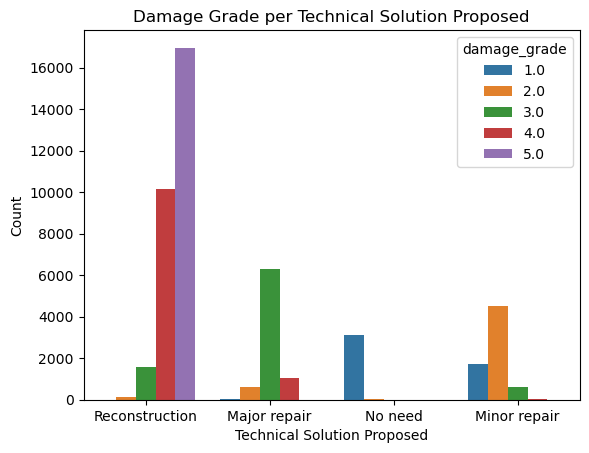

In [18]:
sns.countplot(x="technical_solution_proposed", hue="damage_grade", data=temp)

plt.xlabel("Technical Solution Proposed")
plt.ylabel("Count")
plt.title("Damage Grade per Technical Solution Proposed")
plt.show()

### Predict the missing technical_solution_proposed for imputing train

In [19]:
titr = train.copy()

In [20]:
titr = titr[titr['technical_solution_proposed'].notna()]

In [21]:
titr.shape

(33772, 24)

In [22]:
X_titr = titr[titr.columns.difference(['technical_solution_proposed'])]
y_titr = titr['technical_solution_proposed']

numerical_cols = X_titr.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_titr.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False)

titr_preproc = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

titr_preproc = titr_preproc.fit(train[train.columns.difference(['technical_solution_proposed'])])
X_titr = titr_preproc.transform(X_titr)

titr_le = LabelEncoder()
y_titr = titr_le.fit_transform(y_titr)

In [23]:
cb_titr = XGBClassifier()
f1_avg, f1_std = cross_val_multiclass(cb_titr, X_titr, y_titr)

In [24]:
print(f'Avg: {f1_avg}, Std: {f1_std}')

Avg: 0.9670656336018455, Std: 0.0021510256753391075


In [25]:
cb_titr = XGBClassifier()
cb_titr.fit(X_titr, y_titr, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
train_before = train.copy()

In [27]:
train = train_before.copy()

In [28]:
train.loc[train['technical_solution_proposed'].isna(), 'technical_solution_proposed'] = titr_le.inverse_transform(cb_titr.predict(titr_preproc.transform(train.loc[train['technical_solution_proposed'].isna(), train.columns.difference(['technical_solution_proposed'])]))).ravel()

## Others

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        193502 non-null  float64
 1   old_building                    193502 non-null  float64
 2   plinth_area (ft^2)              193502 non-null  float64
 3   height_before_eq (ft)           193502 non-null  float64
 4   land_surface_condition          193502 non-null  object 
 5   type_of_foundation              193502 non-null  object 
 6   type_of_roof                    193502 non-null  object 
 7   type_of_ground_floor            193502 non-null  object 
 8   type_of_other_floor             193502 non-null  object 
 9   position                        193502 non-null  object 
 10  building_plan_configuration     193502 non-null  object 
 11  technical_solution_proposed     193502 non-null  object 
 12  legal_ownership_

In [30]:
def percentage_table(df, column):
    value_counts = df[column].value_counts()
    total_obs = value_counts.sum()
    percentage = (value_counts / total_obs) * 100
    return pd.concat([value_counts, percentage], axis=1, keys=['Count', 'Percentage'])

In [31]:
percentage_table(train, 'wall_material')

,Count,Percentage
Stone Bricks,157977,81.641017
Unknown/not stated,18674,9.650546
Red Bricks,14343,7.412326
"Red Bricks, Stone Bricks",2508,1.296111


In [32]:
train.drop(['building_plan_configuration', 'legal_ownership_status', 'type_of_reinforcement_concrete',
           'residential_type', 'public_place_type', 'industrial_use_type', 'govermental_use_type', 'flexible_superstructure'], axis=1, inplace=True)

In [33]:
train['total_building_area (ft^2)'] = train['plinth_area (ft^2)'] * train['height_before_eq (ft)']
train['area_to_height_ratio'] = train['plinth_area (ft^2)'] / train['height_before_eq (ft)']
train['height per floor (ft)'] = train['height_before_eq (ft)'] / train['floors_before_eq (total)']
train['tsp_toof'] = train['technical_solution_proposed'] + '_' + train['type_of_other_floor']

In [34]:
train['gross_floor_area'] = train['plinth_area (ft^2)'] * train['floors_before_eq (total)']
train['floor_area_ratio'] = train['total_building_area (ft^2)'] / train['gross_floor_area']

In [35]:
train = train[train['height per floor (ft)'] <= 15]
train = train.reset_index()
train.drop(['index'], axis=1, inplace=True)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192441 entries, 0 to 192440
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   floors_before_eq (total)     192441 non-null  float64
 1   old_building                 192441 non-null  float64
 2   plinth_area (ft^2)           192441 non-null  float64
 3   height_before_eq (ft)        192441 non-null  float64
 4   land_surface_condition       192441 non-null  object 
 5   type_of_foundation           192441 non-null  object 
 6   type_of_roof                 192441 non-null  object 
 7   type_of_ground_floor         192441 non-null  object 
 8   type_of_other_floor          192441 non-null  object 
 9   position                     192441 non-null  object 
 10  technical_solution_proposed  192441 non-null  object 
 11  has_secondary_use            192441 non-null  float64
 12  no_family_residing           192441 non-null  float64
 13 

In [37]:
train.to_csv('train_fed.csv', index=False)

### Re-CL

In [38]:
train = pd.read_csv('train_fed.csv')

In [39]:
train = train.groupby(list(train.columns.difference(['damage_grade']))).filter(lambda x: len(set(x['damage_grade'])) == 1)
train.shape

(192047, 22)

In [40]:
train = train.reset_index()
train.drop(['index'], axis=1, inplace=True)

In [41]:
train = find_label_issue_train(train)
train = train.reset_index()
train.drop(['index'], axis=1, inplace=True)
train.shape

(180953, 22)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180953 entries, 0 to 180952
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   floors_before_eq (total)     180953 non-null  float64
 1   old_building                 180953 non-null  float64
 2   plinth_area (ft^2)           180953 non-null  float64
 3   height_before_eq (ft)        180953 non-null  float64
 4   land_surface_condition       180953 non-null  object 
 5   type_of_foundation           180953 non-null  object 
 6   type_of_roof                 180953 non-null  object 
 7   type_of_ground_floor         180953 non-null  object 
 8   type_of_other_floor          180953 non-null  object 
 9   position                     180953 non-null  object 
 10  technical_solution_proposed  180953 non-null  object 
 11  has_secondary_use            180953 non-null  float64
 12  no_family_residing           180953 non-null  float64
 13 

In [43]:
train.to_csv('train_final.csv', index=False)

In [44]:
train = pd.read_csv('/kaggle/working/train_final.csv')

# Modeling

In [45]:
X = train[train.columns.difference(['damage_grade'])]
y = train['damage_grade']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X = preprocessor.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [46]:
# Create train-validation-test split with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

## Manual

### LightGBM

In [47]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, verbose=0, eval_set=(X_val, y_val))

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [48]:
y_val_pred = lgbm.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4508
           2       0.98      0.99      0.99      3184
           3       1.00      1.00      1.00      5088
           4       0.83      0.68      0.75      5918
           5       0.90      0.95      0.93     17493

    accuracy                           0.92     36191
   macro avg       0.94      0.92      0.93     36191
weighted avg       0.92      0.92      0.92     36191



### CatBoost

In [49]:
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train, verbose=0, eval_set=(X_val, y_val))

In [50]:
y_val_pred = catboost.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4508
           2       0.98      0.99      0.98      3184
           3       1.00      1.00      1.00      5088
           4       0.83      0.70      0.76      5918
           5       0.90      0.95      0.93     17493

    accuracy                           0.92     36191
   macro avg       0.94      0.92      0.93     36191
weighted avg       0.92      0.92      0.92     36191



### XGBoost

In [51]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [52]:
y_val_pred = xgboost.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4508
           2       0.98      0.99      0.99      3184
           3       1.00      1.00      1.00      5088
           4       0.83      0.69      0.76      5918
           5       0.90      0.95      0.93     17493

    accuracy                           0.92     36191
   macro avg       0.94      0.92      0.93     36191
weighted avg       0.92      0.92      0.92     36191



## CV

In [53]:
X_cv, _, y_cv, _ = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

### LightGBM

In [54]:
f1_avg, f1_std = cross_val_multiclass(lgbm, X_cv, y_cv)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. 

In [55]:
print(f'Avg: {f1_avg}, Std: {f1_std}')

Avg: 0.9283316178468322, Std: 0.001522396071962546


### CatBoost

In [56]:
f1_avg, f1_std = cross_val_multiclass(catboost, X_cv, y_cv)

In [57]:
print(f'Avg: {f1_avg}, Std: {f1_std}')

Avg: 0.9287382761791229, Std: 0.0010999191429261566


### XGBoost

In [58]:
f1_avg, f1_std = cross_val_multiclass(xgboost, X_cv, y_cv)

In [59]:
print(f'Avg: {f1_avg}, Std: {f1_std}')

Avg: 0.930808011090465, Std: 0.0015269279914576623


# Prediction

## Pick Model

In [60]:
y_test_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4508
           2       0.99      0.99      0.99      3183
           3       1.00      1.00      1.00      5088
           4       0.84      0.72      0.78      5919
           5       0.91      0.95      0.93     17493

    accuracy                           0.93     36191
   macro avg       0.95      0.93      0.94     36191
weighted avg       0.93      0.93      0.93     36191



In [61]:
test = pd.read_csv('/kaggle/input/jointsugm/test.csv')
test = complete_pipeline_test(test)
test_id = test['id']

In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242082 entries, 0 to 242081
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              242082 non-null  int64  
 1   floors_before_eq (total)        242082 non-null  int64  
 2   old_building                    242082 non-null  int64  
 3   plinth_area (ft^2)              242082 non-null  float64
 4   height_before_eq (ft)           242082 non-null  int64  
 5   land_surface_condition          242082 non-null  object 
 6   type_of_foundation              242082 non-null  object 
 7   type_of_roof                    242082 non-null  object 
 8   type_of_ground_floor            242082 non-null  object 
 9   type_of_other_floor             242082 non-null  object 
 10  position                        242082 non-null  object 
 11  building_plan_configuration     242082 non-null  object 
 12  technical_soluti

In [63]:
test.drop(['building_plan_configuration', 'legal_ownership_status', 'type_of_reinforcement_concrete',
           'residential_type', 'public_place_type', 'industrial_use_type', 'govermental_use_type', 'flexible_superstructure'], axis=1, inplace=True)

test['total_building_area (ft^2)'] = test['plinth_area (ft^2)'] * test['height_before_eq (ft)']
test['area_to_height_ratio'] = test['plinth_area (ft^2)'] / test['height_before_eq (ft)']
test['height per floor (ft)'] = test['height_before_eq (ft)'] / test['floors_before_eq (total)']
test['tsp_toof'] = test['technical_solution_proposed'] + '_' + test['type_of_other_floor']

test['gross_floor_area'] = test['plinth_area (ft^2)'] * test['floors_before_eq (total)']
test['floor_area_ratio'] = test['total_building_area (ft^2)'] / test['gross_floor_area']

test = test[list(train.columns.difference(['damage_grade']))]

In [64]:
test = preprocessor.transform(test)

In [65]:
cb_final = CatBoostClassifier()
cb_final.fit(X, y, verbose=0)

xg_final = XGBClassifier()
xg_final.fit(X, y, verbose=0)

lgbm_final = LGBMClassifier()
lgbm_final.fit(X, y, verbose=0)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [66]:
lgbm_final = LGBMClassifier()
lgbm_final.fit(X, y, verbose=0)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

## Solo Model

### Hard

In [67]:
# pred_test = cb_final.predict(test)
# pred_test = xg_final.predict(test)
pred_test = lgbm_final.predict(test)
sub = pd.DataFrame({
    'id': test_id,
    'damage_grade': pred_test.ravel()
})

sub['damage_grade'] = sub['damage_grade'].apply(lambda x: x+1)

sub.head(5)

,id,damage_grade
0,0,5
1,1,5
2,2,5
3,3,4
4,4,2


In [68]:
sub['damage_grade'].value_counts()

5    110048
3     41110
4     39307
2     32451
1     19166
Name: damage_grade, dtype: int64

In [69]:
sub.to_csv('latest_pipe_true.csv', index=False)

### Prob

In [70]:
tsp_test = pd.read_csv('/kaggle/input/jointsugm/test.csv')[['id', 'technical_solution_proposed']]
tsp_test['technical_solution_proposed'] = tsp_test['technical_solution_proposed'].replace({
    'Reconstruction': 4,
    'Minor repair': 2,
    'Major repair': 3,
    'No need': 1
})
tsp_test

,id,technical_solution_proposed
0,0,4
1,1,4
2,2,4
3,3,4
4,4,2
...,...,...
242077,242077,3
242078,242078,4
242079,242079,1
242080,242080,4


In [71]:
# pred_test = cb_final.predict_proba(test)
# pred_proba_test = xg_final.predict_proba(test)
pred_proba_test = lgbm_final.predict_proba(test)
threshold = 0.70 # set threshold for probability of class 5
sub = pd.DataFrame({
    'id': test_id,
    'damage_grade': [4 if pred[4] <= threshold and pred.argmax() + 1 == 5 else pred.argmax() + 1 for pred in pred_proba_test],
    'cek': tsp_test['technical_solution_proposed']
})

In [72]:
sub['damage_grade'].value_counts()

5    94953
4    54402
3    41110
2    32451
1    19166
Name: damage_grade, dtype: int64

In [73]:
sub['diff'] = sub['damage_grade'] < sub['cek']

In [74]:
sub['diff'].value_counts()

False    239164
True       2918
Name: diff, dtype: int64

In [75]:
sub['damage_grade'] = np.where(sub['diff'], sub['damage_grade'] + 1, sub['damage_grade'])

In [76]:
sub['damage_grade'].value_counts()

5    94953
4    54430
3    41206
2    35093
1    16400
Name: damage_grade, dtype: int64

In [77]:
sub.shape

(242082, 4)

In [78]:
sub.to_csv('grgr.csv', index=False)

In [79]:
sub[['id', 'damage_grade']].to_csv('cobade3.csv', index=False)